## 1. Import libraries

In [2]:
import sys
sys.path.append('../')

%matplotlib inline
from collections import defaultdict
from typing import List
from sklearn.preprocessing import StandardScaler

from matplotlib.ticker import MaxNLocator
from statistics import mean
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
import src.serializer as serializer

## 2. Auxiliary functions

In [35]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

RAM_full_mask=[14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 18  # Chicken Collision flag (with the bottom car)
    , 22  # Car X Direction
    , 23, 24, 25, 26, 27, 28, 29, 30, 31, 32  # Z Car Patterns
    , 33, 34, 35, 36, 37, 38, 39, 40, 41, 42  # Car Motion Timmers
    , 43, 44, 45, 46, 47, 48, 49, 50, 51, 52  # Car Motions
    , 87, 88  # Car Shape Ptr
    # TODO: test if this makes any difference
    , 89, 90  # Chicken Shape Ptr
    # TODO: test if this makes any difference
    #, 106, 107  # Chicken Sounds
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117]  # Car X Coords

### 2.1. Reduce state space

In [27]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob

def reduce_state_abs_neg(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        ob[b] = abs(ob[b] - 50)
        
        if b <= 112:
            ob[b] = -ob[b]
     
        ob[b] = ob[b] // 3

    return ob

### 2.2. Reward policy

In [5]:
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

### 2.3. Print results

In [6]:
def print_result(i, scores, total_reward, score):
#     if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

### 2.4. Renderize a episode

In [7]:
def runGame(env, agent, mask, reduce_state, reduce=True):
    
    actions = []
    score = 0
    total_reward = 0
    
    state = env.reset()
    if reduce:
        state = reduce_state(state)[mask].data.tobytes()  # Select useful bytes
    else:
        state = state[mask].data.tobytes()
        
    action = agent.act(state)
    actions.append(action)
    
    game_over = False
    render  = True
    while not game_over:
        if render:
            time.sleep(0.025)
            env.render()

        old_state = state
        ob, reward, game_over, _ = env.step(action)
        
        if reward == 1:
            score+=1
        total_reward+=reward
        
        if reduce:
            state = reduce_state(ob)[mask].data.tobytes()
        else:
            state = ob[mask].data.tobytes()
            
        action = agent.act(state)
        actions.append(action)
    
    return score, total_reward, actions

## 3. Analysis

For the Q learning function approximator, we decided to use the best parameters found for the Q learning algorithm shown before. They were: 
- $\gamma = 0,99$
- N0 = 0,001
- 2 available actions (move up and stay)
- A reward of 500 if the chicken crosses the street, a reward of -10 if it collides with a car and a reward of -1 if the chicken decides to stay.

One important detail is that, for the function approximator we decided to use a fixed step size $\alpha = 0,00001$. It happened because, when we were using the time varying step size used for the previous algorithms, its values were still much bigger than the necessary for the function approximator error converge, making the score and reward curves decrease instead of increase. With the smaller fixed value of $\alpha$, the updates started to help the algorithm to learn.


### 3.1. Experiment A (Original approximator)

In the figures in this section, we can see the scores and the rewards achieved by the function approximator when it ran for 6000 episodes. As we can see, the scores and rewards were smaller than those achieved for the best Q learning algorithm, and the scores are close to those found for the baseline, which just moves up. 

We also can see that, in the first 500 episodes, the agent achieves bigger scores, with a mean of 23 and maximum value achieving 27 points. However, soon the agent starts to get worse scores and they seem to stabilize close to 21,5 after a few more episodes, varying just a little around it. Also, it is possible to see that the original curve spans a more behaved range of scores. 

The mean score and reward achieved by this agent were 21,49 and 10043,16, respectively. This results indicates that the agent is possibly learning to move up almost every time, what is close to the behavior of the baseline. To check this hypothesis, we watched a sample episode of this agent and saw that the agent chose to move up in all time steps. One possible explanation for it is the small value of N0, which implies a smaller exploration by the agent that seems it is not being enough.

In [9]:
model_exp08 = serializer.Experiment.load_experiment('models/exp08_model_baseline_ql_approximator_6000_2020_12_26_10_07_09.dill')

In [10]:
mean_score_exp08 = np.sum(model_exp08.scores)/len(model_exp08.scores)
mean_reward_exp08 = np.sum(model_exp08.total_rewards)/len(model_exp08.total_rewards)
mean_weights_exp08 = np.sum(model_exp08.agent.W)/len(model_exp08.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp08, mean_reward_exp08, mean_weights_exp08))

Mean score: 21.490666666666666, Mean reward: 10043.158333333333, Mean weights: 43.24854128267378


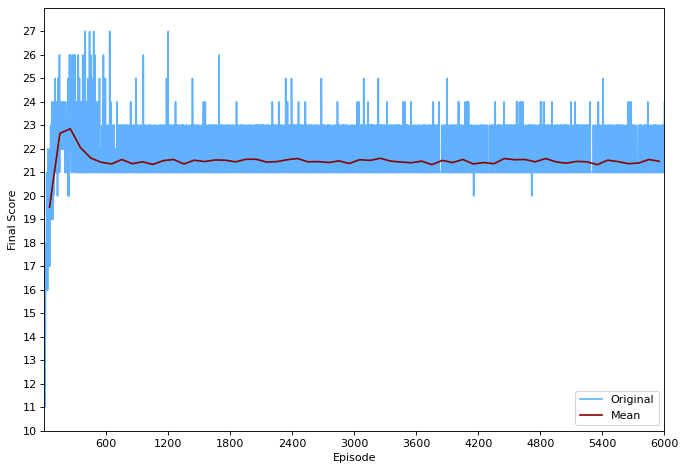

In [11]:
aux_plots.plot_scores_mean(model_exp08.scores)

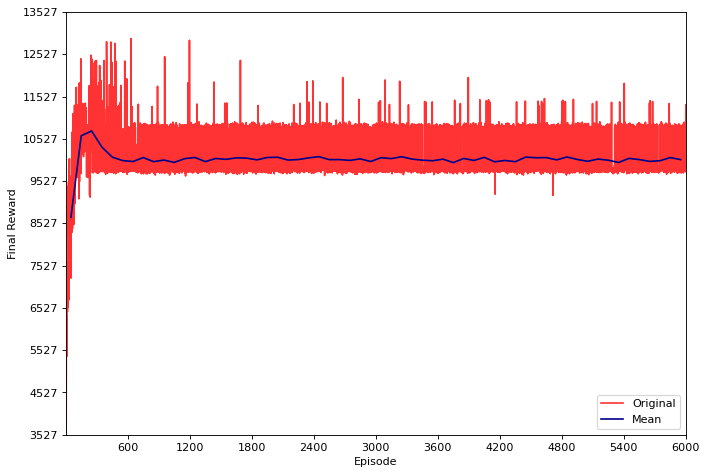

In [12]:
aux_plots.plot_rewards_mean(model_exp08.total_rewards, 1000)

In [14]:
env, initial_state = environment.get_env()
model_exp08.agent.trainScaler(env, RAM_mask)

score_exp08, reward_exp08, actions_exp08 = runGame(env,model_exp08.agent, RAM_mask, reduce_state, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp08, reward_exp08, np.unique(actions_exp08, return_counts=True)))

Score: 21, Reward: 21.0, Actions: (array([1]), array([2717]))


### 3.2. Experimento B (Features without reduce)

In order to analyse the influence of the features used to represent the state-action pairs, we decided to perform some experiments varying these features and keeping those hyperparameters. 

So, the next experiment we performed was the creation of an agent using no reduction to represent the states. We hypothesized that maybe if the agent had a wider view of the environment, it could help it to take better decisions.

This time, the mean score and reward were 21,39 and 9942,23, respectively, which are smaller than those achieved by the previous agent. This indicates that the pre-processed states built with the reduced features provides much better information to the agent than using the raw values obtained from the RAM. However, we can see that the agent scores start to decrease a little later and that the score curve is less behaved than that of the previous agent. This can indicate that the learning process of this agent is slower than that of the original agent. Again, running an episode of the game, the agent always chose to move up.

In [16]:
model_exp04 = serializer.Experiment.load_experiment('models/exp04_model_no_reduce_ql_approximator_6000_2020_12_26_00_25_50.dill')

In [17]:
mean_score_exp04 = np.sum(model_exp04.scores)/len(model_exp04.scores)
mean_reward_exp04 = np.sum(model_exp04.total_rewards)/len(model_exp04.total_rewards)
mean_weights_exp04 = np.sum(model_exp04.agent.W)/len(model_exp04.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp04, mean_reward_exp04, mean_weights_exp04))

Mean score: 21.378166666666665, Mean reward: 9942.233833333334, Mean weights: 25.105749743269037


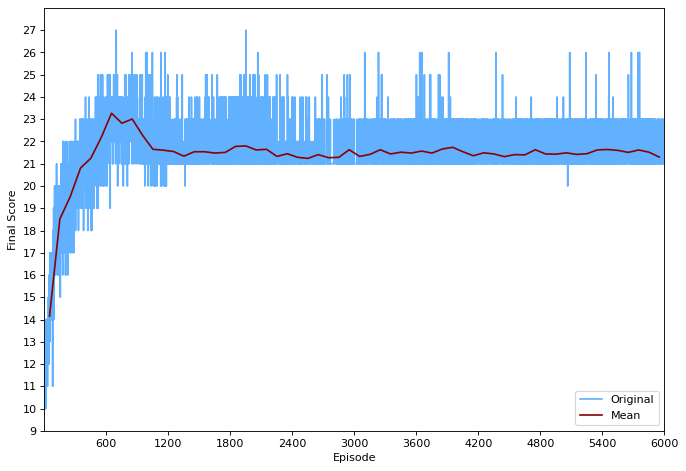

In [18]:
aux_plots.plot_scores_mean(model_exp04.scores)

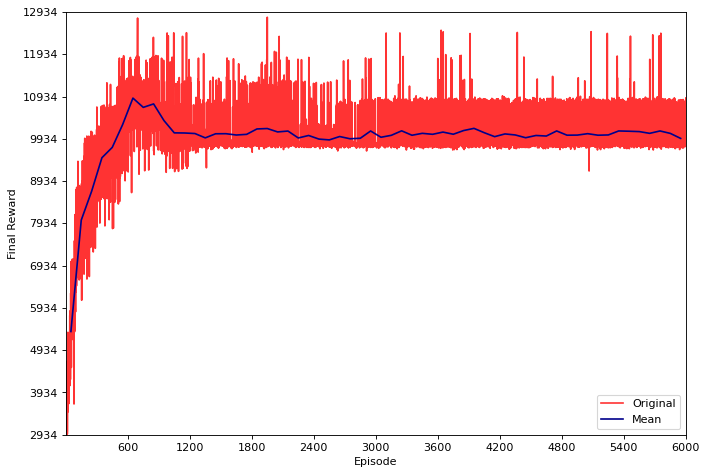

In [19]:
aux_plots.plot_rewards_mean(model_exp04.total_rewards, 1000)

In [20]:
env, initial_state = environment.get_env()
model_exp04.agent.trainScaler(env, RAM_mask)

score_exp04, reward_exp04, actions_exp04 = runGame(env,model_exp04.agent, RAM_mask, reduce_state, False)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp04, reward_exp04, np.unique(actions_exp04, return_counts=True)))

Score: 21, Reward: 21.0, Actions: (array([1]), array([2744]))


### 3.3. Experimento C (Distance features)

Another idea of features that we tried to use with the function approximators was to show to the agent not the position, but the distance each car was from it. Also, we hypothesized that, once half of the cars walk in a direction while the other half walk in the opposite direction, show this to the agent, turning negative the first half of the distances, could also help the agent to better understand the environment and choose better actions.

As we can see in the figures below, these features bring better results than using no pre-processing on the states, but achieved slightly worse results than the original agent, with a mean score and a mean reward of 21,47 and 10025,16. We also can see that the scores started to decrease earlier than the two others seen before and that the curve is a little less behaved than the original, especially in the latter episodes. Again, running an episode, the agent always chooses to move up.

In [23]:
model_exp10 = serializer.Experiment.load_experiment('models/exp10_model_abs_neg_div3_ql_approximator_6000_2020_12_26_10_16_00.dill')

In [24]:
mean_score_exp10 = np.sum(model_exp10.scores)/len(model_exp10.scores)
mean_reward_exp10 = np.sum(model_exp10.total_rewards)/len(model_exp10.total_rewards)
mean_weights_exp10 = np.sum(model_exp10.agent.W)/len(model_exp10.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp10, mean_reward_exp10, mean_weights_exp10))

Mean score: 21.469833333333334, Mean reward: 10025.157, Mean weights: 45.36141153190517


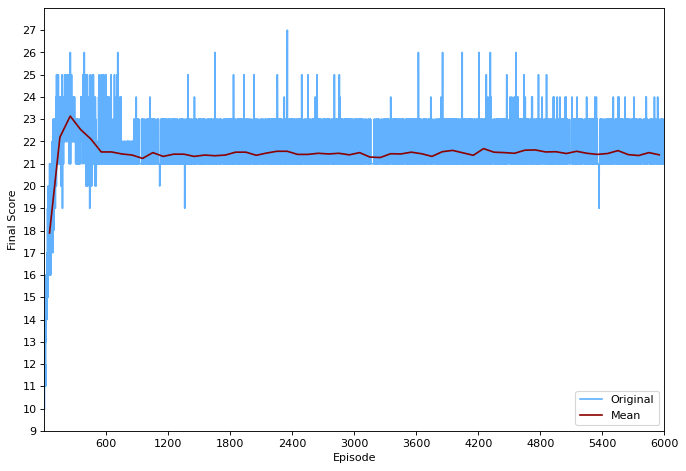

In [25]:
aux_plots.plot_scores_mean(model_exp10.scores)

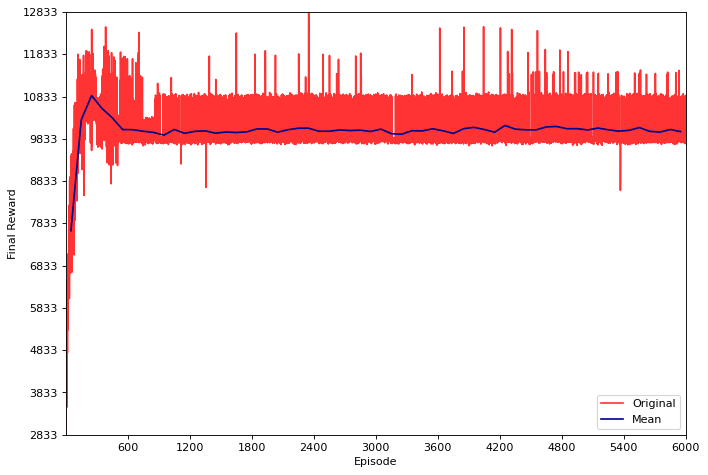

In [26]:
aux_plots.plot_rewards_mean(model_exp10.total_rewards, 1000)

In [28]:
env, initial_state = environment.get_env()
model_exp10.agent.trainScaler(env, RAM_mask)

score_exp10, reward_exp10, actions_exp10 = runGame(env,model_exp10.agent, RAM_mask, reduce_state_abs_neg, True)
# env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp10, reward_exp10, np.unique(actions_exp10, return_counts=True)))

Score: 23, Reward: 23.0, Actions: (array([1]), array([2734]))


### 3.4. Experimento D (Distance features and more RAM)

The next experiment we performed tried to see if passing more information about the environment to the agent, through more RAM bytes that encodes, for example, chicken shapes and car timers, could help in its learning process. For this, we kept the states preprocessing of the previous agent, but we gave more RAM positions.

As can be seen in the figures below, the agent score still starts to decrease earlier, but the curve is less noisy for the latter episodes. The mean score and reward for this agent were 21,44 and 10007,21. Again, the agent decided to always move up when running an episode.


As we could see for the four experiments discussed, the agent is not improving over the baseline. Despite that, the changes in the features generated different behaviors for the agents in the earlier episodes, even converging to a similar bad behavior in the last episodes. Moreover, the creation of more noisy or well behaved score and reward curves indicates the influence of the exploration policy adopted. More well behaved curves indicates that the agent is trying more the best action than exploring other possibilities. More noisy curves could indicate that the presented features could help the agent to achieve better results, probably, if it didn’t always choose the best action.


In [31]:
model_exp09 = serializer.Experiment.load_experiment('models/exp09_model_all_ram_abs_neg_ql_approximator_6000_2020_12_26_10_02_43.dill')

In [32]:
mean_score_exp09 = np.sum(model_exp09.scores)/len(model_exp09.scores)
mean_reward_exp09 = np.sum(model_exp09.total_rewards)/len(model_exp09.total_rewards)
mean_weights_exp09 = np.sum(model_exp09.agent.W)/len(model_exp09.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp09, mean_reward_exp09, mean_weights_exp09))

Mean score: 21.443, Mean reward: 10007.2105, Mean weights: 7.128450485570442


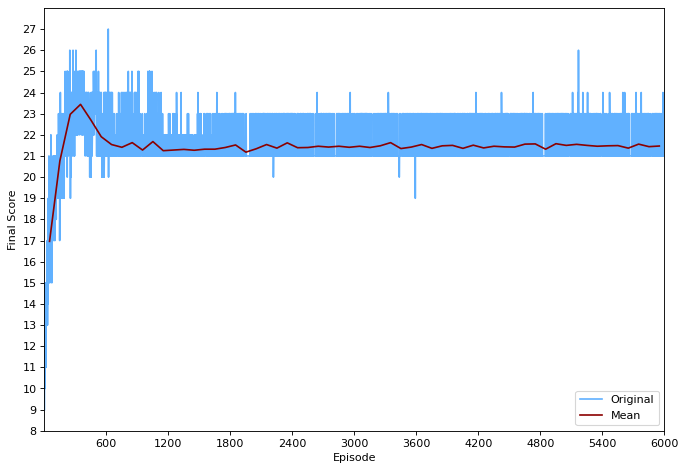

In [33]:
aux_plots.plot_scores_mean(model_exp09.scores)

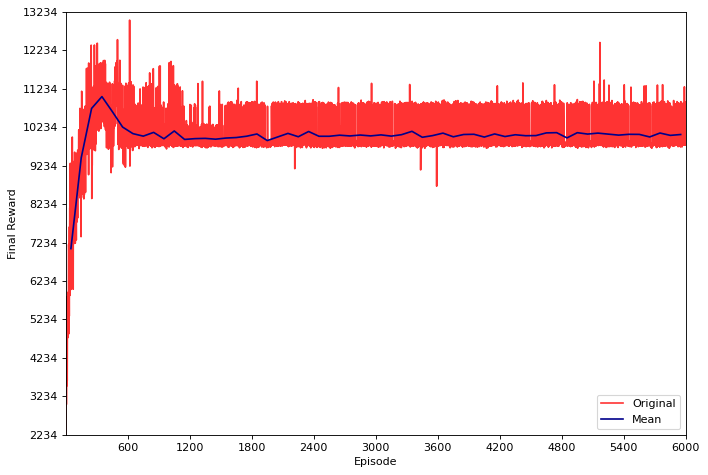

In [34]:
aux_plots.plot_rewards_mean(model_exp09.total_rewards, 1000)

In [36]:
env, initial_state = environment.get_env()
model_exp09.agent.trainScaler(env, RAM_full_mask)

score_exp09, reward_exp09, actions_exp09 = runGame(env,model_exp09.agent, RAM_full_mask, reduce_state_abs_neg, True)
# env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp09, reward_exp09, np.unique(actions_exp09, return_counts=True)))

Score: 23, Reward: 23.0, Actions: (array([1]), array([2732]))


### 3.5. Experimento E (Exploring more)

Given the results obtained with the hyperparameters shown before, we decided to let the Q learning approximator to explore more, now giving N0 = 2,5. 

In the figures below, we can see that the score and reward curves changed their shapes, not presenting that big decrease in the first episodes. The bigger exploration manifests in the noisier curves, showing that sometimes the agent chooses actions that drive it to greater scores and rewards, and other times its decisions generate bad results, as expected from an agent that is exploring more.

This time, the mean score and reward were 22,61 and 10560,47, which are better than the baseline and the previous results, but still worse than the best results achieved for the Q learning model without function approximation. Moreover, now the agent chooses to don’t move in some time steps. For a sample running, the agent chose to don’t move for 14 of the 2754 time steps. These results indicate that now we were able to build an agent that decides better when to take a given action in a given situation.

In [39]:
model_exp02 = serializer.Experiment.load_experiment('models/exp02_model_r3_ql_approximator_6000_2020_12_25_12_00_15.dill')

In [40]:
mean_score_exp02 = np.sum(model_exp02.scores)/len(model_exp02.scores)
mean_reward_exp02 = np.sum(model_exp02.total_rewards)/len(model_exp02.total_rewards)
mean_weights_exp02 = np.sum(model_exp02.agent.W)/len(model_exp02.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp02, mean_reward_exp02, mean_weights_exp02))

Mean score: 22.6125, Mean reward: 10560.471333333333, Mean weights: 58.32817639375868


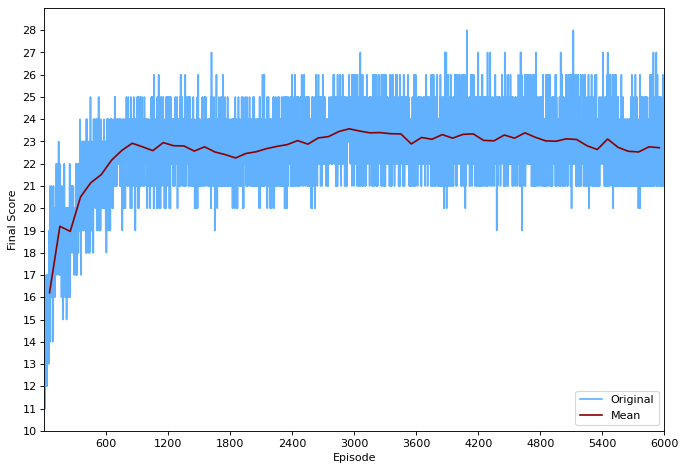

In [41]:
aux_plots.plot_scores_mean(model_exp02.scores)

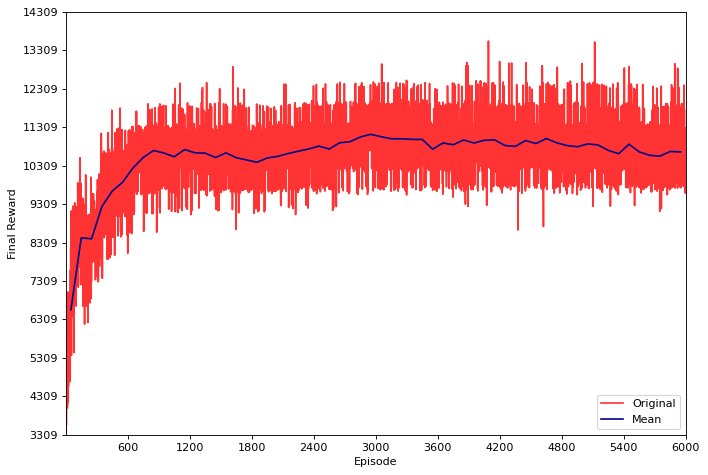

In [42]:
aux_plots.plot_rewards_mean(model_exp02.total_rewards, 1000)

In [47]:
# setattr(model_exp02.agent, 'feat_type', 'all')
env, initial_state = environment.get_env()
model_exp02.agent.trainScaler(env, RAM_mask)

score_exp02, reward_exp02, actions_exp02 = runGame(env,model_exp02.agent, RAM_mask, reduce_state, True)
env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp02, reward_exp02, np.unique(actions_exp02, return_counts=True)))

Score: 22, Reward: 22.0, Actions: (array([0, 1]), array([  14, 2740]))


### 3.6. Experiment F (-50 for collision)

Given that the results of the Q learning approximator were not good enough, compared with the Q learning without the approximation, we tried to perform other changes that could help the agent to learn. Watching some episodes of the created agent, we saw that it was colliding with cars a lot of times. So, we hypothesized that changing the reward function, given a bigger negative value for the collision, would help the agent to learn to collide less.

To check it, we performed two more experiments, keeping N0 equal to 2,5. In one of them we gave a reward of -50 when the chicken collided with a car, and in the other we gave a reward of -100.

The two figures below show the results for the reward of -50. As we can see, the curve of scores is very similar to that using the original rewards. Nevertheless, the reward curve shows much more variation in its values, as a consequence of the bigger negative reward. These results indicate that this change in the reward function was not able to decrease sufficiently the number of collisions.  The mean score and reward for this agent were 22,54 and 7876,18, which are smaller than that of the agent with the original reward policy. And, again, the agent learned to don’t move in some few situations.


In [56]:
model_exp11 = serializer.Experiment.load_experiment('models/exp11_model_r50_approximator_6000_2020_12_26_22_27_33.dill')

In [57]:
mean_score_exp11 = np.sum(model_exp11.scores)/len(model_exp11.scores)
mean_reward_exp11 = np.sum(model_exp11.total_rewards)/len(model_exp11.total_rewards)
mean_weights_exp11 = np.sum(model_exp11.agent.W)/len(model_exp11.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp11, mean_reward_exp11, mean_weights_exp11))

Mean score: 22.544166666666666, Mean reward: 7876.183, Mean weights: 44.923679223856524


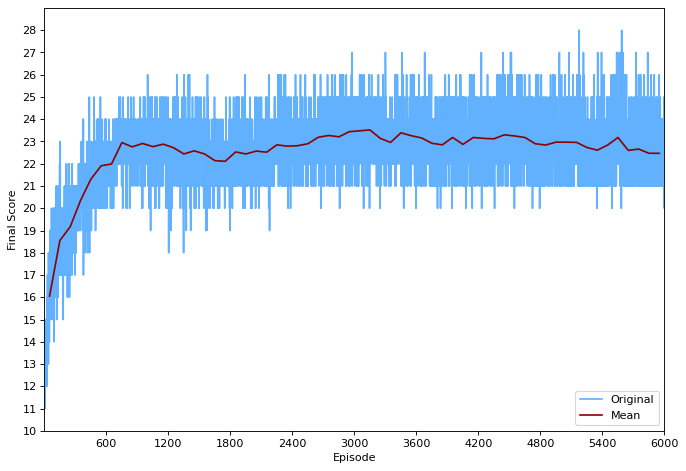

In [58]:
aux_plots.plot_scores_mean(model_exp11.scores)

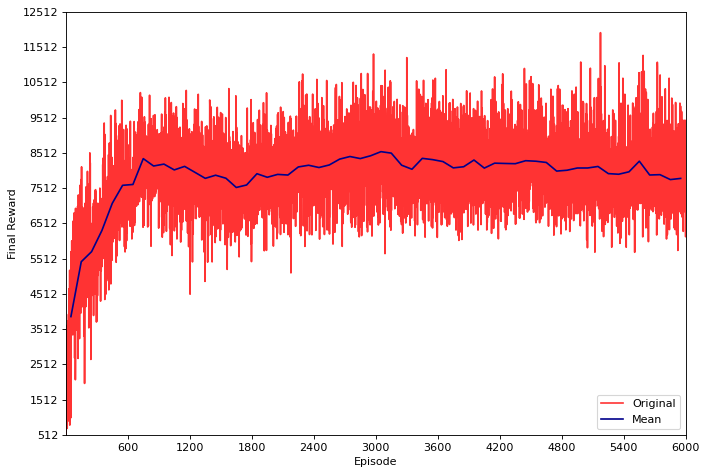

In [59]:
aux_plots.plot_rewards_mean(model_exp11.total_rewards, 1000)

In [60]:
env, initial_state = environment.get_env()
model_exp11.agent.trainScaler(env, RAM_mask)

score_exp11, reward_exp11, actions_exp11 = runGame(env,model_exp11.agent, RAM_mask, reduce_state, True)
# env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp11, reward_exp11, np.unique(actions_exp11, return_counts=True)))

Score: 22, Reward: 22.0, Actions: (array([0, 1]), array([  15, 2713]))


### 3.7. Experiment G (-100 for collision)

Using a reward of -100 when the chicken collides with a car gaves us a score curve that is slightly more stable than using a reward of -50. However, it is still very similar with the score curve built using the original reward policy. The reward curve, on the other hand, has much bigger amplitudes than the other two, as expected, but also has less variant mean values. The mean score and reward for this agent were 22,59 and 4617,35, and it also choses to don’t move in some time steps, but in less time steps than the other two.

With these results we could see that changes in the reward policy was not good enough to prevent the chicken from colliding and, consequently, achieving better scores.


In [62]:
model_exp12 = serializer.Experiment.load_experiment('models/exp12_model_r100_approximator_6000_2020_12_26_23_04_24.dill')

In [63]:
mean_score_exp12 = np.sum(model_exp12.scores)/len(model_exp12.scores)
mean_reward_exp12 = np.sum(model_exp12.total_rewards)/len(model_exp12.total_rewards)
mean_weights_exp12 = np.sum(model_exp12.agent.W)/len(model_exp12.agent.W)
print('Mean score: {}, Mean reward: {}, Mean weights: {}'.format(mean_score_exp12, mean_reward_exp12, mean_weights_exp12))

Mean score: 22.595666666666666, Mean reward: 4617.357, Mean weights: 28.691696205376754


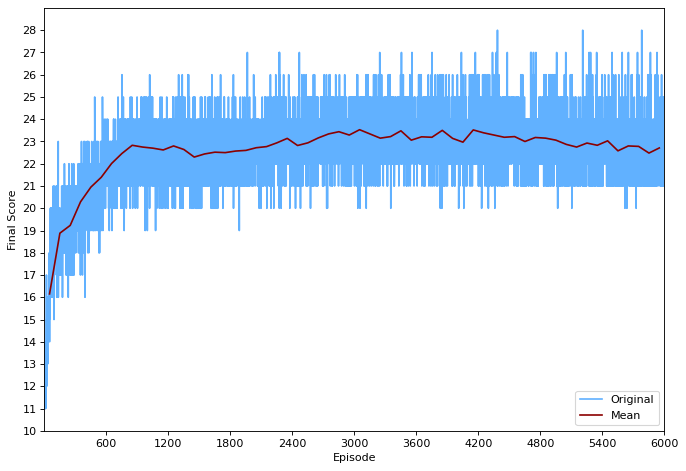

In [64]:
aux_plots.plot_scores_mean(model_exp12.scores)

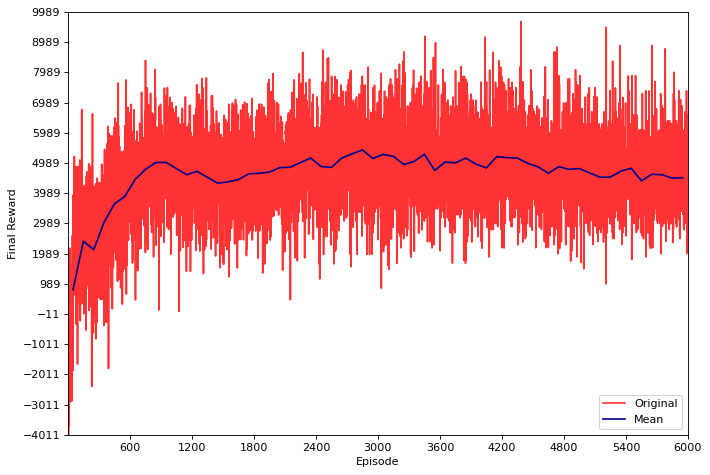

In [65]:
aux_plots.plot_rewards_mean(model_exp12.total_rewards, 1000)

In [68]:
env, initial_state = environment.get_env()
model_exp12.agent.trainScaler(env, RAM_mask)

score_exp12, reward_exp12, actions_exp12 = runGame(env,model_exp12.agent, RAM_mask, reduce_state, True)
# env.close()

print('Score: {}, Reward: {}, Actions: {}'.format(score_exp12, reward_exp12, np.unique(actions_exp12, return_counts=True)))

Score: 21, Reward: 21.0, Actions: (array([0, 1]), array([  13, 2723]))


## 4. Conclusions

In the table below we can see a summary of the mean scores and rewards for each experiment.

| Experiment | Mean Score | Mean Reward |
|:----------:|:----------:|:-----------:|
|      A     |    21,49   |   10043,16  |
|      B     |    21,39   |   9942,23   |
|      C     |    21,47   |   10025,16  |
|      D     |    21,44   |   10007,21  |
|      E     |    22,61   |   10560,47  |
|      F     |    22,54   |   7876,18   |
|      G     |    22,59   |   4617,35   |


As we could see from the results, the function approximation implemented for the Q learning algorithm didn’t improve the performance of the agents, compared to the Q learning without approximation, as we were expecting. Some factors could explain that, such as the choice of better hyperparameters, but one of the most important is the creation of the features.

As discussed in the introduction about function approximation, the features are a key factor for the success of these algorithms, both because they decrease the dimension space of the values we are trying to optimize and because they are responsible for expressing the most important information that the agent will use to learn about the environment.

Although the linear function approximators are powerful algorithms for a lot of reinforcement learning tasks, they have some disadvantages. One of them is its lack of capacity to express some kind of relationships between environment variables. For example, if a given variable represents a good event in the environment only in the absence of another, the linear approximator cannot parameterize that. In these cases, the features become responsible for representing the necessary information for the learning process, requiring good feature engineering.

Given that and the results achieved with function approximators in this project, we assume that the features chosen by us, probably, were not very representative of our problem, for function approximation. So, for future works, we need to investigate better representations and try with more complex function approximators, such as the nonlinear ones. Despite that, we could see how the exploration capacity of the agent  and the rewards chosen can impact how good it becomes, as well as how the learning step size contributes to the convergence of the algorithms.
